In [ ]:
# @title Monta il drive su colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Setup Librerie
import os
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# @title Definizione dei path
# Path per accedere ai risultati sul validation set di VSLNet
pred_dir_vslnet = "/content/drive/MyDrive/training/training_best_200_GLOVE_vslnet_omnivore_2/omnivore_video_fp16/vslnet_nlq_official_v1_omnivore_video_fp16_official_128_glove/model/"
# Path per accedere ai risultati sul validation set di VSLBase
pred_dir_vslbase = "/content/drive/MyDrive/training/training_best_200_GLOVE_vslbase_omnivore_2/omnivore_video_fp16/vslbase_nlq_official_v1_omnivore_video_fp16_official_128_glove/model/"
# Path per accedere ai ground truth sul dataset di validazione
gt_path = "/content/drive/MyDrive/backup_colab/content/ego4d_data/v1/annotations/nlq_val.json"
# Path per salvare i risultati
output_dir = "/content/drive/MyDrive/Risultati/VSL+Omnivore/GloVe"
os.makedirs(output_dir, exist_ok=True)


# Percorso del file delle short queries
short_queries_path = "/content/drive/MyDrive/Risultati/short_queries_val.json"

# Carica le short queries
with open(short_queries_path) as f:
    short_queries = json.load(f)

# Costruisci il set dei bad_keys (tuple)
bad_keys = {
    (q["clip_uid"], q["annotation_uid"], q["query_idx"])
    for q in short_queries
}

SPIEGAZIONE STEP SUCCESSIVI

METRICA INTERSECTION OVER UNION (IoU/ Jaccard similarity/ Jaccard Index) \\
DEF: IoU =  $\frac{\text{Area of intersection}}{\text{Area over Union}}$ \\
IoU $\geq$ 0.5 is "decent" \\
IoU $\geq$ 0.7 is "pretty good" \\
IoU $\geq$ 0.9 is "almost perfect" \\


Per selezionare il .json file migliore, si usa il criterio Rank@1 IoU@0.5 ->
Ti dice quante volte la prima predizione (top-1) del modello ha un'IoU ≥ 0.5 rispetto al segmento annotato (ground truth).
NOTA: Lo 0.5 è un compromesso classico tra tolleranza e precisione, usato anche in altri task di detection
Operativamente, viene selezionato il j.son file che ha quanti più clip con primo intervallo di previsione con IoU >0.5

In [ ]:
# Funzione che calcola IoU (versione più corretta)
def compute_iou(s1, e1, s2, e2):
    # calcolo intersezione
    inter = max(0, min(e1, e2) - max(s1, s2))

    # calcolo area di ciascun segmento
    area1 = max(0, e1 - s1)
    area2 = max(0, e2 - s2)

    # union corretta
    union = area1 + area2 - inter

    return inter / (union + 1e-6)

# Funzione per costruzione dizionario per ground truth
def load_gt(gt_path):
  # Apro .json file con le annotazioni sul valitation
    with open(gt_path) as f:
        ann_data = json.load(f)
    # Inizializzo un dizionario vuoto
    gt_lookup = {}
    # Per ogni video nel file di annotazione
    for video in ann_data["videos"]:
      # Per ogni clip corrispondente a un video nel file
        for clip in video["clips"]:
          # Salvo l'identificativo del clip
            clip_uid = clip["clip_uid"]
            # Per ogni annotazione in un clip
            for annotation in clip["annotations"]:
              # Salvo l'identificativo dell'annotazione
                annotation_uid = annotation["annotation_uid"]
                # Per ogni query contenute nell'elenco language_queries
                for query_idx, query in enumerate(annotation.get("language_queries", [])):
                    if "query" not in query:
                        continue
                    # Definisco la chiave identificativa del dizionario, coincidente con id del clip, id della annotazione, indice della query
                    key = (clip_uid, annotation_uid, query_idx)
                    # Salvo le informazioni d'interesse
                    gt_lookup[key] = {
                        # Salvo video_uid per risalire al video e fare eventuali plot
                        "video_uid": video["video_uid"],
                        # gt_start è l'inizio del ground truth per la query d'interesse
                        "gt_start": query["clip_start_sec"],
                        # gt_end è la fine del ground truth per la query d'interesse
                        "gt_end": query["clip_end_sec"],
                        # query è proprio la domanda che viene formulata
                        "query": query["query"],
                         # template è il tipo di domanda che viene fatta
                        "template": query["template"],
                        # è l'istante di inizio della clip considerata, rispetto all'interezza del video, MA NON DOVREBBE SERVIRE
                        "clip_start_sec": clip["video_start_sec"]
                    }
    return gt_lookup


# Funzione per selezionare il .json file migliore, secondo la metrica RANK@1 IoU@0.3
def evaluate_predictions(pred_dir, gt_lookup, top_k=[1, 5], iou_thr=0.3):
    best_file = None             # File .json con le predizioni migliori
    best_recall = -1             # Miglior valore di recall osservato finora
    json_files = sorted(glob.glob(os.path.join(pred_dir, "*.json")))  # Tutti i file .json salvati

    # Cicla su tutti i .json file (ogni file rappresenta un checkpoint di un modello: epoca+iterazione)
    for file in json_files:
        try:
            # Carica le predizioni da file (contenute dentro l'item results)
            with open(file) as f:
                pred_data = json.load(f)["results"]
            tmp_records = []

            # Cicla su ogni previsione nel file
            for item in pred_data:
              # Definisco la chiave univoca che caratterizza ogni previsione (analoga a gt_lookup)
                key = (item["clip_uid"], item["annotation_uid"], item["query_idx"])

                # Se non c'è il ground truth per questa tripla oppure non ci sono predizioni, salta
                if key not in gt_lookup or not item.get("predicted_times"):
                    continue

                gt = gt_lookup[key]                     # Ground truth segment
                #clip_start = gt["clip_start_sec"]       # Inizio del clip (per correggere i tempi)
                # Inizializzo una lista che contenga gli ious di ogni previsione per ogni file
                ious = []

                # Ciclo sulle 5 predizioni di una data query
                for i in range(min(len(item["predicted_times"]), max(top_k))):
                    # Memorizzo gli istanti di inizio e fine predetti nell'i-esima previsione, sono gli istanti rispetto al VIDEO, proprio come le info memorizzate nel GT
                    pred_start, pred_end = item["predicted_times"][i]

                    # Calcola l’IoU tra predizione e ground truth
                    iou = compute_iou(pred_start, pred_end, gt["gt_start"], gt["gt_end"])
                    # Aggiungo l'iou calcolato alla lista
                    ious.append(iou)

                # Salva solo la iou@1 (cioè quella della prima predizione)
                tmp_records.append({f"iou@1": ious[0]})

            # Costruisce un DataFrame con tutte le iou@1 e calcola il recall = % di predizioni con iou >= soglia
            tmp_df = pd.DataFrame(tmp_records)
            recall = (tmp_df["iou@1"] >= iou_thr).mean()  # ≈ Rank@1@0.5

            # Se è il miglior risultato visto finora, aggiorna
            if recall > best_recall:
                best_recall = recall
                best_file = file
        except:
            continue  # In caso di errore nel file, va avanti
    return best_file  # Ritorna il file con il miglior Rank@1@0.5 (approssimato come recall)

# Funzione per costruire un dataframe con tutte le informazioni utili per ogni query
# INPUTS:
# pred_file = .json file riferito all'epoca+iterazione migliore secondo la metrica Rank@1 IoU@0.3 ottenuto dalla funzione precedente. presenta dato un clip_uid, annotation_uid, query_idx 5 predicted times
# gt_lookup = dizionario avente chiave identificativa (clip_uid, annotation_uid, query_idx) in maniera conforme alle informazioni contenute nel .json file, ottenuto dalla funzione load_gt.
# Contiene template, query, gt_start e gt_end come informazioni di interesse

# OUTPUT:
# Restituisce un dataframe che per ogni (clip_uid, annotation_uid, query_idx) restituisce query, template della query, istanti predetti e gt, window_length

def build_dataframe(pred_file, gt_lookup, top_k=[1, 5]):
    # Apro il .json file con le previsioni
    with open(pred_file) as f:
        pred_data = json.load(f)["results"]
    # Inizializzo il dataframe
    records = []
    # Scorro dentro il file con le previsioni
    for item in pred_data:
        # Memorizzo in key le informazioni univoche che caratterizzano la query predetta
        key = (item["clip_uid"], item["annotation_uid"], item["query_idx"])
        # Controllo che esiste una query corrispondente nel dizionario di gt e che per quella query ci sia l'item predicted_times
        if key not in gt_lookup or not item.get("predicted_times"):
            continue
        # Accedo alla query nel file di gt
        gt = gt_lookup[key]
        # Inizializzo lista con ious
        ious = []
        # Ciclo sulle i previsioni fornite nel .json file per ogni query
        for i in range(min(len(item["predicted_times"]), max(top_k))):
            # Salvo tempo di inizio e tempo di file per la query corrispondenti alla previsione i
            pred_start, pred_end = item["predicted_times"][i]
            # Calcolo la iou
            iou = compute_iou(pred_start, pred_end, gt["gt_start"], gt["gt_end"])
            # Aggiungo la iou alla lista
            ious.append(iou)
        # Salvo le informazioni
        records.append({
             # IDENTIFICATIVI DELLA QUERY
            "clip_uid": item["clip_uid"], # Add clip_uid to the dataframe
            "annotation_uid": item["annotation_uid"], # Add annotation_uid to the dataframe
            "query_idx": item["query_idx"], # Add query_idx to the dataframe
             # Salvo video_uid per risalire al video di appartenenza della query quando facciamo i plot
             "video_uid": gt["video_uid"],
             # Salvo il template della query per verificare se ci sono template più problematici di altri
             "template": gt["template"],
            "query": gt["query"],
            "gt_start": gt["gt_start"],
            "gt_end": gt["gt_end"],
            # pred_start è il primo istante (su 5) predetto come tempo iniziale per rispondere alla query di interesse
            "pred_start": item["predicted_times"][0][0],
            # pred_end è il primo istante (su 5) predetto come tempo finale per rispondere alla query di interesse
            "pred_end": item["predicted_times"][0][1],
            # iou calcolata in base alla prima previsione per quella query
            "iou": ious[0],
            # Per ogni valore k in top_k (es. [1, 5]): prende le prime k previsioni (ious[:k]) calcola la migliore IoU tra le prime k predizioni, se ci sono meno di k previsioni, mette 0.0
            **{f"iou@{k}": max(ious[:k]) if len(ious) >= k else 0.0 for k in top_k}
        })
    # Costruisco dataframe
    df = pd.DataFrame(records)
    # Creo una nuova colonna chiamata gt_len, ovvero la lunghezza dell'intervallo gt
    df["gt_len"] = df["gt_end"] - df["gt_start"]
    # Creo una nuova colonna chiamata gt_len, ovvero la lunghezza dell'intervallo predetto
    df["pred_len"] = df["pred_end"] - df["pred_start"]
    # Creo una nuova colonna chiamata length_error contentente la differenza, ovvero moment_length_errorr
    df["length_error"] = df["pred_len"] - df["gt_len"]
    return df

# Funzione per l' istogramma IoU
def plot_iou_histogram_comparison(df1, df2, label1, label2, output_path_base, bins=10, alpha=0.7):
    """
    Crea due istogrammi comparativi dell'IoU tra df1 e df2:
    1. Inclusi tutti gli intervalli [0.0, 1.0]
    2. Escludendo l'intervallo [0.0, 0.1)

    Salva entrambe le figure nella cartella di output_path_base, usando come base il nome file.
    """
    # Estraggo directory e filename base
    output_dir = os.path.dirname(output_path_base)
    base_filename = os.path.splitext(os.path.basename(output_path_base))[0]
    os.makedirs(output_dir, exist_ok=True)

    def plot_single_histogram(data1, data2, bin_edges, suffix):
        bin_width = bin_edges[1] - bin_edges[0]
        counts1, _ = np.histogram(data1["iou"], bins=bin_edges)
        counts2, _ = np.histogram(data2["iou"], bins=bin_edges)

        plt.figure(figsize=(10, 6))
        plt.bar(
            bin_edges[:-1], counts1, width=bin_width,
            align='edge', alpha=alpha, label=label1,
            edgecolor='black', linewidth=1.2, color='royalblue'
        )
        plt.bar(
            bin_edges[:-1], counts2, width=bin_width,
            align='edge', alpha=alpha, label=label2,
            edgecolor='black', linewidth=1.2, color='salmon'
        )

        plt.xlabel("Intersection over Union (IoU)", fontsize=14)
        plt.ylabel("# of Samples", fontsize=14)
        plt.xticks(bin_edges, [f"{x:.1f}" for x in bin_edges])
        plt.legend(fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()

        output_file = os.path.join(output_dir, f"{base_filename}_{suffix}.png")
        plt.savefig(output_file)
        plt.show()

    # Primo plot: tutti gli intervalli da 0.0 a 1.0
    bin_edges_all = np.linspace(0, 1, bins + 1)
    plot_single_histogram(df1, df2, bin_edges_all, "with_0.0")

    # Secondo plot: da 0.1 a 1.0, escludendo il primo intervallo
    bin_edges_cut = np.linspace(0.1, 1, bins)
    plot_single_histogram(df1[df1["iou"] >= 0.1],
                          df2[df2["iou"] >= 0.1],
                          bin_edges_cut, "without_0.0")



# Funzione che plotta Moment Lenght Error tra VSLBase e VSLNet OK
def plot_length_error_comparison_lines(df1, df2, label1, label2, output_path, bins=30):
    counts1, bin_edges = np.histogram(df1["length_error"], bins=bins)
    counts2, _ = np.histogram(df2["length_error"], bins=bin_edges)

    # Calcola i centri dei bin per tracciare la linea
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    plt.figure(figsize=(8,5))
    plt.plot(bin_centers, counts1, label=label1, color='blue', marker='o')
    plt.plot(bin_centers, counts2, label=label2, color='red', marker='o')
    plt.axvline(0, color='black', linestyle='--')
    plt.xlabel("Moment Length Error (seconds)")
    plt.ylabel("# of Samples")
    plt.title("Moment Length Error Comparison")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()

# Seleziono 5 casi significativi
def seleziona_casi_specifici(df_base, df_net):
    df_base = df_base.copy()
    df_net = df_net.copy()

    # Usa la chiave composta da clip_uid, annotation_uid, query_idx per il merge
    df_base["key"] = list(zip(df_base["clip_uid"], df_base["annotation_uid"], df_base["query_idx"]))
    df_net["key"] = list(zip(df_net["clip_uid"], df_net["annotation_uid"], df_net["query_idx"]))

    # Merge su "key"
    merged = pd.merge(df_net, df_base, on="key", suffixes=("_net", "_base"))

    # 1. Miglior caso per VSLNet
    best_net_row = merged.loc[merged["iou_net"].idxmax()]

    # 2. Miglior caso per VSLBase
    best_base_row = merged.loc[merged["iou_base"].idxmax()]

    # 3. Peggior caso per VSLNet
    worst_net_row = merged.loc[merged["iou_net"].idxmin()]

    # 4. Peggior caso per VSLBase
    worst_base_row = merged.loc[merged["iou_base"].idxmin()]

    # 5. Caso in cui VSLNet è molto meglio del Base
    merged["diff_net_base"] = merged["iou_net"] - merged["iou_base"]
    net_better_row = merged.loc[merged["diff_net_base"].idxmax()]

    return {
        "best_net": best_net_row,
        "best_base": best_base_row,
        "worst_net": worst_net_row,
        "worst_base": worst_base_row,
        "net_better": net_better_row
    }

# Funzione per fare il grafico dei 5 casi significativi
def plot_cinque_casi_riformattato(casi_dict, output_path):
    casi_labels = {
        "best_net": "Best VSLNet",
        "best_base": "Best VSLBase",
        "worst_net": "Worst VSLNet",
        "worst_base": "Worst VSLBase",
        "net_better": "VSLNet >> VSLBase"
    }

    colors = {"GT": "green", "VSLBase": "gold", "VSLNet": "skyblue"}

    fig, axs = plt.subplots(5, 1, figsize=(12, 10), sharex=False)

    for i, (key, row) in enumerate(casi_dict.items()):
        gt_start = row["gt_start_net"] if "gt_start_net" in row else row["gt_start"]
        gt_end = row["gt_end_net"] if "gt_end_net" in row else row["gt_end"]

        axs[i].hlines(3, gt_start, gt_end, color=colors["GT"], linewidth=5, label="GT")
        axs[i].hlines(2, row["pred_start_base"], row["pred_end_base"], color=colors["VSLBase"], linewidth=5, label="VSLBase")
        axs[i].hlines(1, row["pred_start_net"], row["pred_end_net"], color=colors["VSLNet"], linewidth=5, label="VSLNet")

        axs[i].set_yticks([1, 2, 3])
        axs[i].set_yticklabels(["VSLNet", "VSLBase", "GT"])
        axs[i].set_title(f"{casi_labels[key]}\nQuery: {row['query_net'][:100]}", fontsize=10, loc="left")
        axs[i].grid(True, axis="x", linestyle="--", alpha=0.4)
        axs[i].spines[['top','right','left']].set_visible(False)

    # Sposto la legenda fuori dal grafico, a destra
    axs[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))

    plt.xlabel("Time (s)")
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()

# Funzione per tabella riepilogativa
def build_results_table(data_list, output_path):
    rows = []
    for df, model_name, feature_name in data_list:
        row = [
            model_name,
            feature_name,
            f"{(df['iou@1'] >= 0.3).mean() * 100:.2f}",
            f"{(df['iou@5'] >= 0.3).mean() * 100:.2f}",
            f"{(df['iou@1'] >= 0.5).mean() * 100:.2f}",
            f"{(df['iou@5'] >= 0.5).mean() * 100:.2f}",
        ]
        rows.append(row)

    # Aggiungi baseline
    rows.append(["VSLNet", "FastFeatures", "5.65", "10.76", "3.12", "6.63"])

    col_labels = [
        "Modello", "Feature Extractor",
        "IoU=0.3\nR@1", "IoU=0.3\nR@5",
        "IoU=0.5\nR@1", "IoU=0.5\nR@5"
    ]

    fig, ax = plt.subplots(figsize=(11, 0.6 + len(rows) * 0.6))
    ax.axis('off')

    table = ax.table(
        cellText=rows,
        colLabels=col_labels,
        cellLoc='center',
        loc='center'
    )

    table.auto_set_font_size(False)
    table.set_fontsize(13)
    table.scale(1.6, 1.6)

    plt.title("Performance Riassuntiva - VSL + Feature Extractor", pad=20, fontsize=14)
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()


In [ ]:
# @ title Correzione dei file nel Drive per VSLBase (PIETRO SEI UN POLLO HAI SALVATO I RISULTATI DI VSLBASE COME VSLNET!!!)
import os
import glob
import shutil

# Cartella contenente i file da correggere
folder_path = "/content/drive/MyDrive/training/training_best_200_GLOVE_vslbase_omnivore_2/omnivore_video_fp16/vslbase_nlq_official_v1_omnivore_video_fp16_official_128_glove/model/"

# Trova tutti i file JSON
json_files = glob.glob(os.path.join(folder_path, "*.json"))

for file_path in json_files:
    file_name = os.path.basename(file_path)
    if file_name.startswith("vslnet_"):
        new_name = file_name.replace("vslnet_", "vslbase_", 1)
        new_path = os.path.join(folder_path, new_name)
        if not os.path.exists(new_path):
            shutil.copy(file_path, new_path)
            print(f"✅ Copiato:\n  {file_name} → {new_name}")
        else:
            print(f"⚠️ Esiste già: {new_name} (niente fatto)")


✅ Copiato:
  vslnet_0_322_preds.json → vslbase_0_322_preds.json
✅ Copiato:
  vslnet_1_1288_preds.json → vslbase_1_1288_preds.json
✅ Copiato:
  vslnet_0_644_preds.json → vslbase_0_644_preds.json
✅ Copiato:
  vslnet_1_1290_preds.json → vslbase_1_1290_preds.json
✅ Copiato:
  vslnet_0_645_preds.json → vslbase_0_645_preds.json
✅ Copiato:
  vslnet_2_1610_preds.json → vslbase_2_1610_preds.json
✅ Copiato:
  vslnet_1_966_preds.json → vslbase_1_966_preds.json
✅ Copiato:
  vslnet_2_1932_preds.json → vslbase_2_1932_preds.json
✅ Copiato:
  vslnet_30_19642_preds.json → vslbase_30_19642_preds.json
✅ Copiato:
  vslnet_32_21285_preds.json → vslbase_32_21285_preds.json
✅ Copiato:
  vslnet_33_21930_preds.json → vslbase_33_21930_preds.json
✅ Copiato:
  vslnet_2_1935_preds.json → vslbase_2_1935_preds.json
✅ Copiato:
  vslnet_3_2254_preds.json → vslbase_3_2254_preds.json
✅ Copiato:
  vslnet_3_2576_preds.json → vslbase_3_2576_preds.json
✅ Copiato:
  vslnet_3_2580_preds.json → vslbase_3_2580_preds.json
✅ Copi

In [ ]:
# @title Selezione del miglior file di predizione per VSLBase e Net
gt_lookup = load_gt(gt_path)
best_vslnet = evaluate_predictions(pred_dir_vslnet, gt_lookup)
best_vslbase = evaluate_predictions(pred_dir_vslbase, gt_lookup)

print("\n📌 VSLNet miglior file:", best_vslnet)
print("📌 VSLBase miglior file:", best_vslbase)


# SELEZIONO I MIGLIORI PREDS FILE
# Senza remove val nel vslnet
#best_vslnet2 = "/content/drive/MyDrive/training/training_best_200_GLOVE_vslnet_omnivore/omnivore_video_fp16/vslnet_nlq_official_v1_omnivore_video_fp16_official_128_glove/model/vslnet_141_91590_preds.json"
# Con remove val nel vslnet
#best_vslnet2 = "/content/drive/MyDrive/training/training_best_200_GLOVE_vslnet_omnivore_2/omnivore_video_fp16/vslnet_nlq_official_v1_omnivore_video_fp16_official_128_glove/model/vslnet_141_91590_preds.json"
df_vslnet = build_dataframe(best_vslnet, gt_lookup)
#best_vslbase = "/content/drive/MyDrive/training/training_best_200_GLOVE_vslbase_omnivore_2/omnivore_video_fp16/vslbase_nlq_official_v1_omnivore_video_fp16_official_128_glove/model/vslbase_82_53130_preds.json"
df_vslbase = build_dataframe(best_vslbase, gt_lookup)


📌 VSLNet miglior file: /content/drive/MyDrive/training/training_best_200_GLOVE_vslnet_omnivore_2/omnivore_video_fp16/vslnet_nlq_official_v1_omnivore_video_fp16_official_128_glove/model/vslnet_141_91590_preds.json
📌 VSLBase miglior file: /content/drive/MyDrive/training/training_best_200_GLOVE_vslbase_omnivore_2/omnivore_video_fp16/vslbase_nlq_official_v1_omnivore_video_fp16_official_128_glove/model/vslbase_82_53130_preds.json


In [ ]:
# @title Verifico che effettivamente le query in bad keys abbiamo IoU <0.1
def check_bad_keys_have_zero_iou(df, bad_keys):
    # Filtra solo le righe del dataframe i cui identificatori sono nei bad_keys
    df_bad = df[df.apply(lambda row: (row["clip_uid"], row["annotation_uid"], row["query_idx"]) in bad_keys, axis=1)]

    # Trova le righe in cui la iou è >0.1
    df_non_zero_iou = df_bad[df_bad["iou"] > 0.1]

    if not df_non_zero_iou.empty:
        print("⚠️ Alcuni bad_keys hanno iou diversa da zero:")
        print(df_non_zero_iou[["clip_uid", "annotation_uid", "query_idx", "iou"]])
    else:
        print("✅ Tutti i bad_keys hanno iou < 0.1 come previsto.")

check_bad_keys_have_zero_iou(df_vslbase, bad_keys)
check_bad_keys_have_zero_iou(df_vslnet, bad_keys)

✅ Tutti i bad_keys hanno iou < 0.1 come previsto.
✅ Tutti i bad_keys hanno iou < 0.1 come previsto.


In [ ]:
# Rimuovo bad keys
def remove_bad_keys(df, bad_keys):
    return df[~df.apply(lambda row: (row["clip_uid"], row["annotation_uid"], row["query_idx"]) in bad_keys, axis=1)]
df_vslbase = remove_bad_keys(df_vslbase, bad_keys)
df_vslnet = remove_bad_keys(df_vslnet, bad_keys)

In [ ]:
print(len(bad_keys))

440


In [ ]:
# Quanti elementi ci sono nel ground truth?
print("Numero di coppie (clip, annotation, query) nel GT:", len(gt_lookup))

# Quanti record stai effettivamente valutando?
print("Record con almeno una predizione valida:")
print("  VSLBase:", len(df_vslbase))
print("  VSLNet: ", len(df_vslnet))


# Conteggi per TUTTI i bin [0.0–0.1), [0.1–0.2), …, [0.9–1.0)
all_bins = np.linspace(0, 1, 11)
counts_base_all, _ = np.histogram(df_vslbase["iou"], bins=all_bins)
counts_net_all,  _ = np.histogram(df_vslnet["iou"],  bins=all_bins)

print("\nConteggi completi per ogni intervallo di IoU:")
for left, right, cb, cn in zip(all_bins[:-1], all_bins[1:], counts_base_all, counts_net_all):
    print(f"[{left:.1f}, {right:.1f}) -> VSLBase: {cb}, VSLNet: {cn}")


Numero di coppie (clip, annotation, query) nel GT: 3874
Record con almeno una predizione valida:
  VSLBase: 3529
  VSLNet:  3529

Conteggi completi per ogni intervallo di IoU:
[0.0, 0.1) -> VSLBase: 3228, VSLNet: 3141
[0.1, 0.2) -> VSLBase: 91, VSLNet: 105
[0.2, 0.3) -> VSLBase: 51, VSLNet: 68
[0.3, 0.4) -> VSLBase: 46, VSLNet: 52
[0.4, 0.5) -> VSLBase: 39, VSLNet: 45
[0.5, 0.6) -> VSLBase: 26, VSLNet: 38
[0.6, 0.7) -> VSLBase: 19, VSLNet: 33
[0.7, 0.8) -> VSLBase: 15, VSLNet: 23
[0.8, 0.9) -> VSLBase: 8, VSLNet: 18
[0.9, 1.0) -> VSLBase: 6, VSLNet: 6


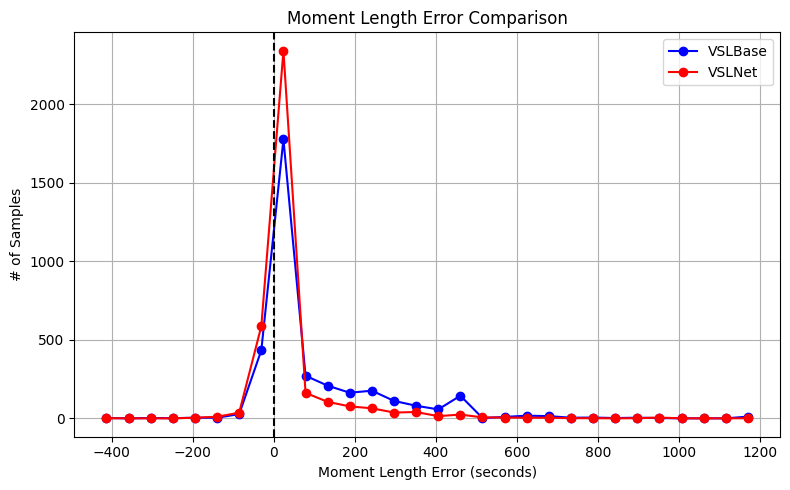

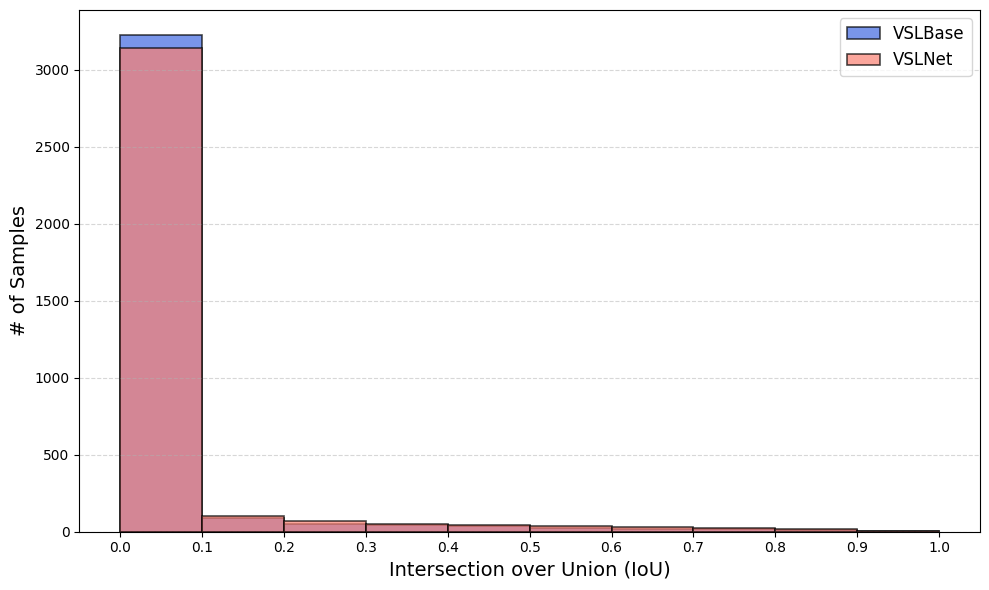

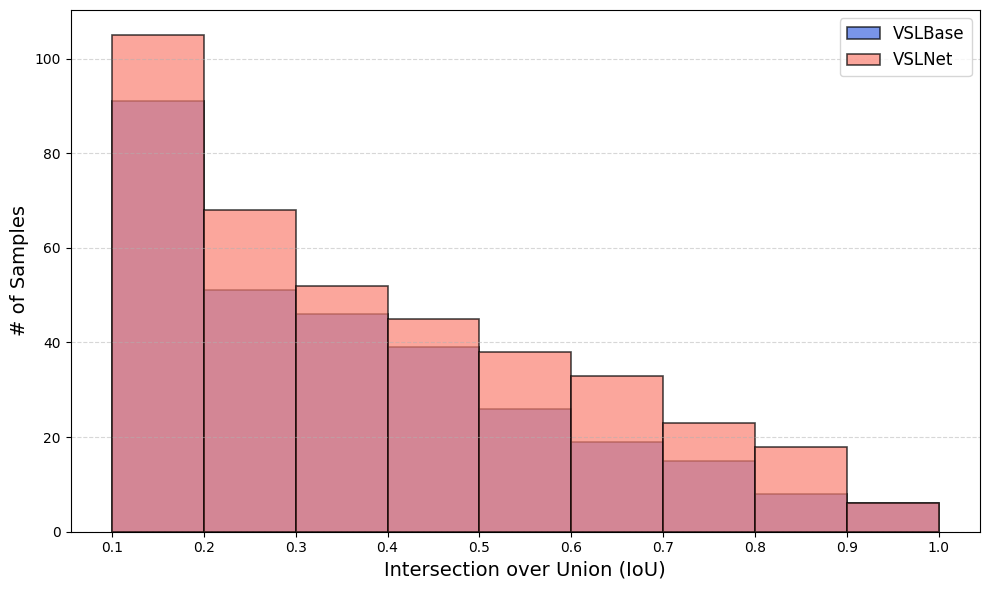

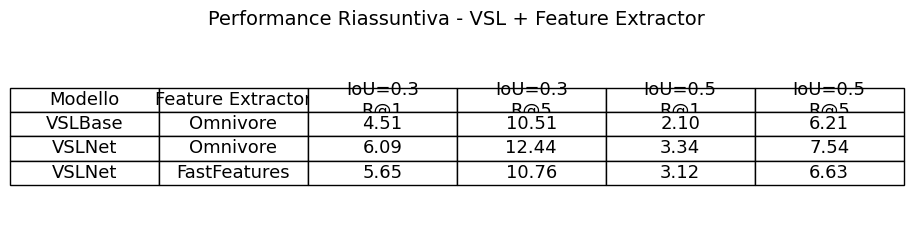

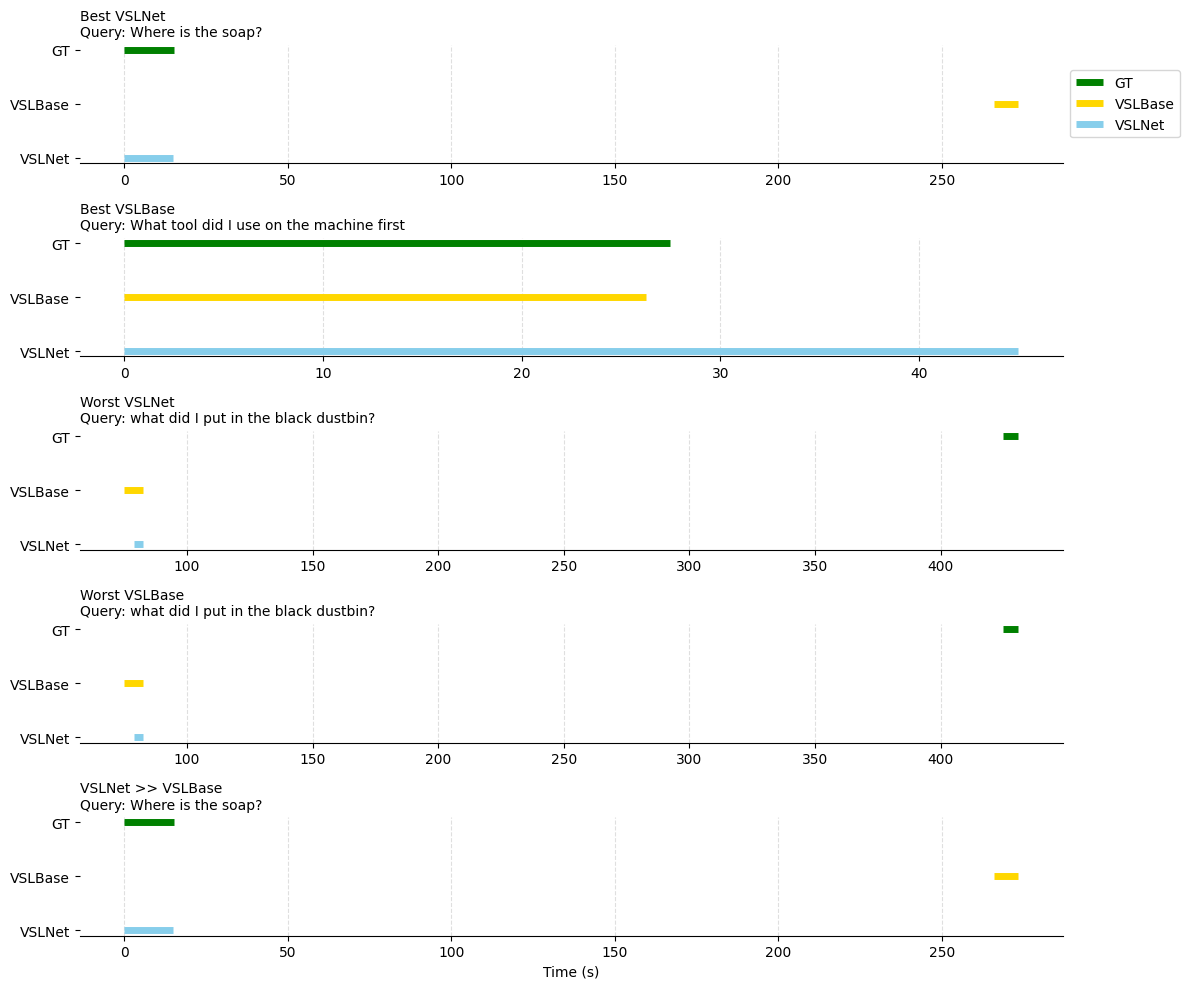

In [ ]:
# @title Plot e tabelle per l'analisi dei risultati ottenuti

# Plot Moment Length Error
plot_length_error_comparison_lines(df_vslbase, df_vslnet, "VSLBase", "VSLNet", os.path.join(output_dir, "moment_length_error.png"))

# Plot Istogramma IoU
plot_iou_histogram_comparison(
    df_vslbase,
    df_vslnet,
    "VSLBase",
    "VSLNet",
    os.path.join(output_dir, "iou_histogram")
)

# Tabella riassuntiva
build_results_table(
    data_list=[
        (df_vslbase, "VSLBase", "Omnivore"),
        (df_vslnet, "VSLNet", "Omnivore"),
    ],
    output_path=os.path.join(output_dir, "tabella_riassuntiva_omnivore.png")
)

# Plotta 5 clip significativi
cinque_casi = seleziona_casi_specifici(df_vslbase, df_vslnet)
plot_cinque_casi_riformattato(cinque_casi, os.path.join(output_dir, "cinque_casi_rappresentativi.png"))

Moment Lenght Error (da articolo 4)\\
Viene misurata la differenza tra la lunghezza dei momenti predetti e il ground truth. Una differenza di lunghezza positiva indica che il momento predetto è più lungo del ground truth corrispondente, mentre una lunghezza negativa il contrario. Nella figura si vede che VSLBase tende a predire momenti più lunghi, mentre al contrario VSLNet, vincolato da QGH, tende a predire momenti più corti.


Istogramma IoU \\
La figura mostra gli istrogrammi dei risultati predetti sul validation set.
VSLNet presenta più campioni per gli IoU più altri, quindi per esempio IoU >= 0.7. Questo dimostra l'efficacia della strategia QGH.


Tabella riassuntiva
VSLNet + Omnivore il migliore in ogni caso



In [ ]:
# Dedurre da qui info su video_uid e iou per i 5 casi rappresentativi
print(cinque_casi)

{'best_net': clip_uid_net                        5726971c-b3cc-43ed-8071-f6ee143e417d
annotation_uid_net                  1a039f8c-10c1-4740-8fb4-f4e9120d533e
query_idx_net                                                          1
video_uid_net                       584f625d-15b0-49e8-bfa6-718b9cf010e0
template_net                                 Objects: Where is object X?
query_net                                             Where is the soap?
gt_start_net                                                         0.0
gt_end_net                                                       15.0723
pred_start_net                                                       0.0
pred_end_net                                                   14.983334
iou_net                                                         0.994097
iou@1_net                                                       0.994097
iou@5_net                                                       0.994097
gt_len_net                            

In [ ]:
# Filtra le predizioni con IoU molto bassa
low_iou_vslnet = df_vslnet[(df_vslnet["iou"] >= 0.0) & (df_vslnet["iou"] <= 0.1)]
low_iou_vslbase = df_vslbase[(df_vslbase["iou"] >= 0.0) & (df_vslbase["iou"] <= 0.1)]
for i, row in low_iou_vslnet.head(5).iterrows():
    print(f"🔹 Query: {row['query']}")
    print(f"  GT:     {row['gt_start']:.2f} - {row['gt_end']:.2f} ({row['gt_len']:.2f}s)")
    print(f"  Pred:   {row['pred_start']:.2f} - {row['pred_end']:.2f} ({row['pred_len']:.2f}s)")
    print(f"  IoU:    {row['iou']:.4f}")
    print(f"  Error Length: {row['length_error']:.2f}\n")

for i, row in low_iou_vslbase.head(5).iterrows():
    print(f"🔹 Query: {row['query']}")
    print(f"  GT:     {row['gt_start']:.2f} - {row['gt_end']:.2f} ({row['gt_len']:.2f}s)")
    print(f"  Pred:   {row['pred_start']:.2f} - {row['pred_end']:.2f} ({row['pred_len']:.2f}s)")
    print(f"  IoU:    {row['iou']:.4f}")
    print(f"  Error Length: {row['length_error']:.2f}\n")


🔹 Query: what did I put in the black dustbin?
  GT:     425.00 - 431.00 (6.00s)
  Pred:   78.75 - 82.50 (3.75s)
  IoU:    0.0000
  Error Length: -2.25

🔹 Query: who did I talk to in  the house?
  GT:     465.00 - 472.00 (7.00s)
  Pred:   18.75 - 82.50 (63.75s)
  IoU:    0.0000
  Error Length: 56.75

🔹 Query: In what location did I see white dustbin?
  GT:     173.90 - 174.00 (0.10s)
  Pred:   0.00 - 82.50 (82.50s)
  IoU:    0.0000
  Error Length: 82.40

🔹 Query: where did I put carton?
  GT:     178.00 - 184.00 (6.00s)
  Pred:   423.75 - 427.50 (3.75s)
  IoU:    0.0000
  Error Length: -2.25

🔹 Query: Who did I interact with when I played with the dog for the second time in the living room?
  GT:     384.00 - 393.07 (9.07s)
  Pred:   18.75 - 52.50 (33.75s)
  IoU:    0.0000
  Error Length: 24.68

🔹 Query: what did I put in the black dustbin?
  GT:     425.00 - 431.00 (6.00s)
  Pred:   75.00 - 82.50 (7.50s)
  IoU:    0.0000
  Error Length: 1.50

🔹 Query: who did I talk to in  the house?
 

2943


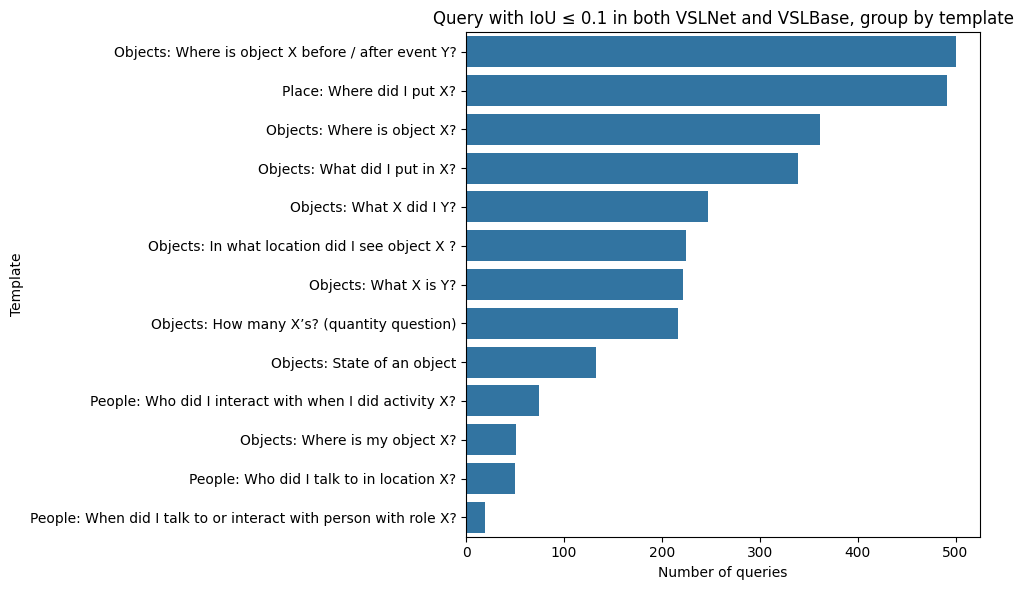

In [ ]:
# @title Exam failure cases

# Seleziono query con iou basso per vsl net
low_iou_vslnet = df_vslnet[(df_vslnet["iou"] >= 0.0) & (df_vslnet["iou"] <= 0.1)]
# Seleziono query con iou basso per vsl base
low_iou_vslbase = df_vslbase[(df_vslbase["iou"] >= 0.0) & (df_vslbase["iou"] <= 0.1)]

# Crea set di chiavi identificative
low_keys_vslnet = set(zip(low_iou_vslnet["clip_uid"], low_iou_vslnet["annotation_uid"], low_iou_vslnet["query_idx"]))
low_keys_vslbase = set(zip(low_iou_vslbase["clip_uid"], low_iou_vslbase["annotation_uid"], low_iou_vslbase["query_idx"]))

# Intersezione: query con IoU ≤ 0.1 in entrambi i modelli
low_keys_common = low_keys_vslnet.intersection(low_keys_vslbase)
# Stampo il numero di casi che falliscono per entrambi
print(len(low_keys_common))

# Creo dataframe con quei casi (prendo vsl net perchè tanto l'info sul template che mi serve dopo non cambia tra base e net)
low_common_df = df_vslnet[df_vslnet.apply(lambda row: (row["clip_uid"], row["annotation_uid"], row["query_idx"]) in low_keys_common, axis=1)]


plt.figure(figsize=(10, 6))
sns.countplot(data=low_common_df, y="template", order=low_common_df["template"].value_counts().index)
plt.title("Query with IoU ≤ 0.1 in both VSLNet and VSLBase, group by template")
plt.xlabel("Number of queries")
plt.ylabel("Template")
plt.tight_layout()
plt.show()


Da questo plot emerge che i modelli hanno le performance comunemente peggiori su specifiche tipologie di query. In particolare,  i modelli fanno più difficoltà a predire correttamente le query associate ai template "Place: Where I did put X", "Where is object X before/ after event Y?", Where is object X?, What did I put in X? Che erano le tipologie di query che erano risultate essere associate a finestre di risposta più strette durante l'esplorazione del dataset iniziale.

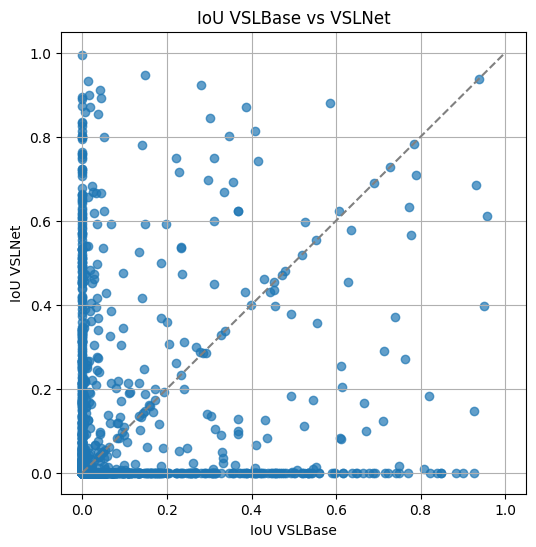

In [ ]:
# Confronto con uno scatter plot come sono gli andamenti dei due modelli. Sulla diagonale ci sono le query azzeccate da entrambi, sopra quelle di vslnet, sotto quelle da vslbase

plt.figure(figsize=(6,6))
plt.scatter(df_vslbase["iou"], df_vslnet["iou"], alpha=0.7)
plt.xlabel("IoU VSLBase")
plt.ylabel("IoU VSLNet")
plt.title("IoU VSLBase vs VSLNet")
plt.plot([0,1], [0,1], '--', color='gray')
plt.grid()
plt.show()


GUIDA PER LEGGERE IL GRAFICO \\
Asse X: IoU ottenuto da VSLBase \\
Asse Y: IoU ottenuto da VSLNet \\
Ogni punto rappresenta una singola query su cui entrambi i modelli sono stati valutati.

Diagonale tratteggiata (y = x)
Punti sulla diagonale → i due modelli hanno ottenuto lo stesso IoU su quella query.
Punti sopra la diagonale → VSLNet ha performato meglio (IoU più alto).
Punti sotto la diagonale → VSLBase ha performato meglio.

INTERPRETAZIONE
1. Prevalenza di punti sopra la diagonale
Conferma che VSLNet è un miglioramento effettivo del modello base.

2. Densità vicino allo 0 (in basso a sinistra)
Molte query hanno IoU ≈ 0 per entrambi i modelli, quindi non sono state predette correttamente da nessuno dei due. Questo può indicare:
Query particolarmente ambigue o difficili.
Clip troppo brevi/lunghe o query poco informative.

3. Punti sul bordo sinistro (x ≈ 0, y > 0)
VSLBase fallisce completamente (IoU ≈ 0), ma VSLNet riesce a predire bene → forte miglioramento.

4. Punti sul bordo inferiore (y ≈ 0, x > 0)
Rari nel tuo caso → conferma che VSLBase raramente supera VSLNet.

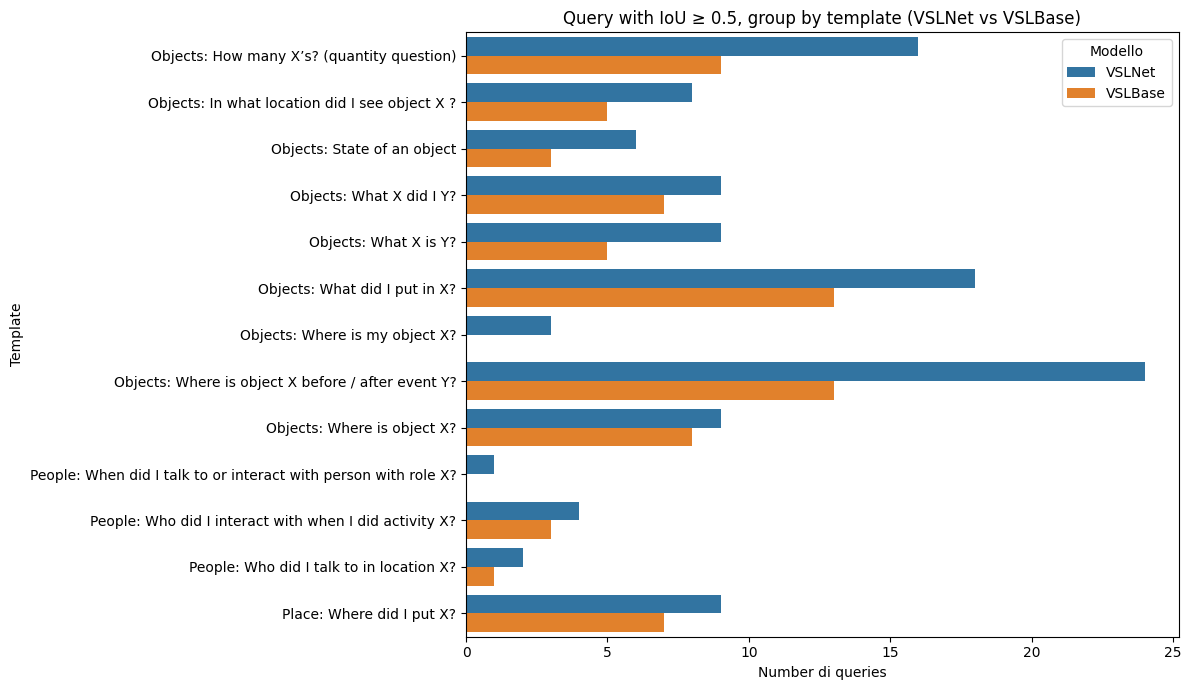

In [ ]:
# @title Indaghiamo gli andamenti dei modelli sui tipi di query sono meglio predetti

# Seleziono query con iou buono per vsl net
high_iou_vslnet = df_vslnet[(df_vslnet["iou"] >=0.5)]

# Seleziono query con iou buono per vsl base
high_iou_vslbase = df_vslbase[(df_vslbase["iou"] >= 0.5)]

# Calcola conteggio query per template con IoU >= 0.5
counts_vslnet = high_iou_vslnet['template'].value_counts()
counts_vslbase = high_iou_vslbase['template'].value_counts()

# Crea un DataFrame con i conteggi
df_plot = pd.DataFrame({
    'template': counts_vslnet.index.union(counts_vslbase.index),  # Unione di tutti i template
    'VSLNet': counts_vslnet,
    'VSLBase': counts_vslbase
}).fillna(0)

# Porta in formato "long"
df_long = df_plot.melt(id_vars='template', var_name='model', value_name='count')

# Plot
plt.figure(figsize=(12, 7))
sns.barplot(data=df_long, x='count', y='template', hue='model')
plt.title("Query with IoU ≥ 0.5, group by template (VSLNet vs VSLBase)")
plt.xlabel("Number di queries")
plt.ylabel("Template")
plt.tight_layout()
plt.legend(title="Modello")
plt.show()



Da questo grafico emerge che il Net è in grado di predire meglio del Base per ogni tipo di query. In particolare, per alcuni task come Where is my object X e
When did I talk to or interact with person wih role X? il Net è l'unico ad azzeccarci, anche se in pochi casi.

In [ ]:
# @title Blox plot finale per template
# Aggiungi una colonna 'key' a entrambi
df_vslnet["key"] = list(zip(df_vslnet["clip_uid"], df_vslnet["annotation_uid"], df_vslnet["query_idx"]))
df_vslbase["key"] = list(zip(df_vslbase["clip_uid"], df_vslbase["annotation_uid"], df_vslbase["query_idx"]))

# Costruisci DataFrame con info da entrambi
merged = pd.merge(
    df_vslnet[["key", "iou", "template"]].rename(columns={"iou": "iou_vslnet", "template": "template_vslnet"}),
    df_vslbase[["key", "iou", "template"]].rename(columns={"iou": "iou_vslbase", "template": "template_vslbase"}),
    on="key"
)


/tmp/ipython-input-41-2081838212.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(
/tmp/ipython-input-41-2081838212.py:15: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/tmp/ipython-input-41-2081838212.py:15: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.pointplot(


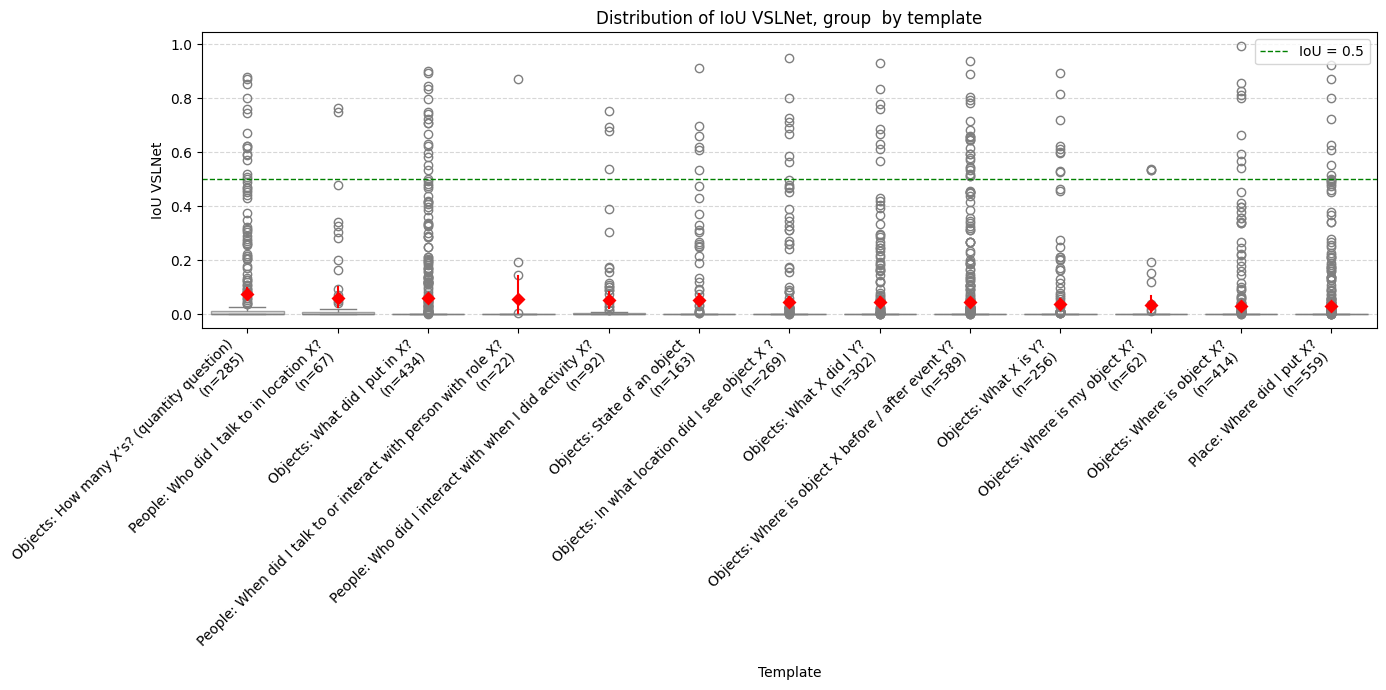

In [ ]:
# Calcolo della media IoU per ordinare i template
media_iou = merged.groupby("template_vslnet")["iou_vslnet"].mean().sort_values(ascending=False)
ordered_templates = media_iou.index

plt.figure(figsize=(14, 7))
sns.boxplot(
    data=merged,
    x="template_vslnet",
    y="iou_vslnet",
    order=ordered_templates,
    color='lightgray',
    boxprops=dict(alpha=0.7)
)

sns.pointplot(
    data=merged,
    x="template_vslnet",
    y="iou_vslnet",
    order=ordered_templates,
    estimator='mean',
    ci=95,
    color='red',
    markers='D',
    linestyles='',
    scale=1.0,
    errwidth=1.5
)

# Aggiungi soglia
plt.axhline(0.5, color='green', linestyle='--', linewidth=1, label='IoU = 0.5')

# Etichette con numero di campioni
counts = merged['template_vslnet'].value_counts()
new_labels = [f"{t}\n(n={counts[t]})" for t in ordered_templates]
plt.xticks(ticks=range(len(new_labels)), labels=new_labels, rotation=45, ha = 'right')

plt.title("Distribution of IoU VSLNet, group  by template")
plt.xlabel("Template")
plt.ylabel("IoU VSLNet")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()




/tmp/ipython-input-42-2007629664.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(
/tmp/ipython-input-42-2007629664.py:15: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/tmp/ipython-input-42-2007629664.py:15: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.pointplot(


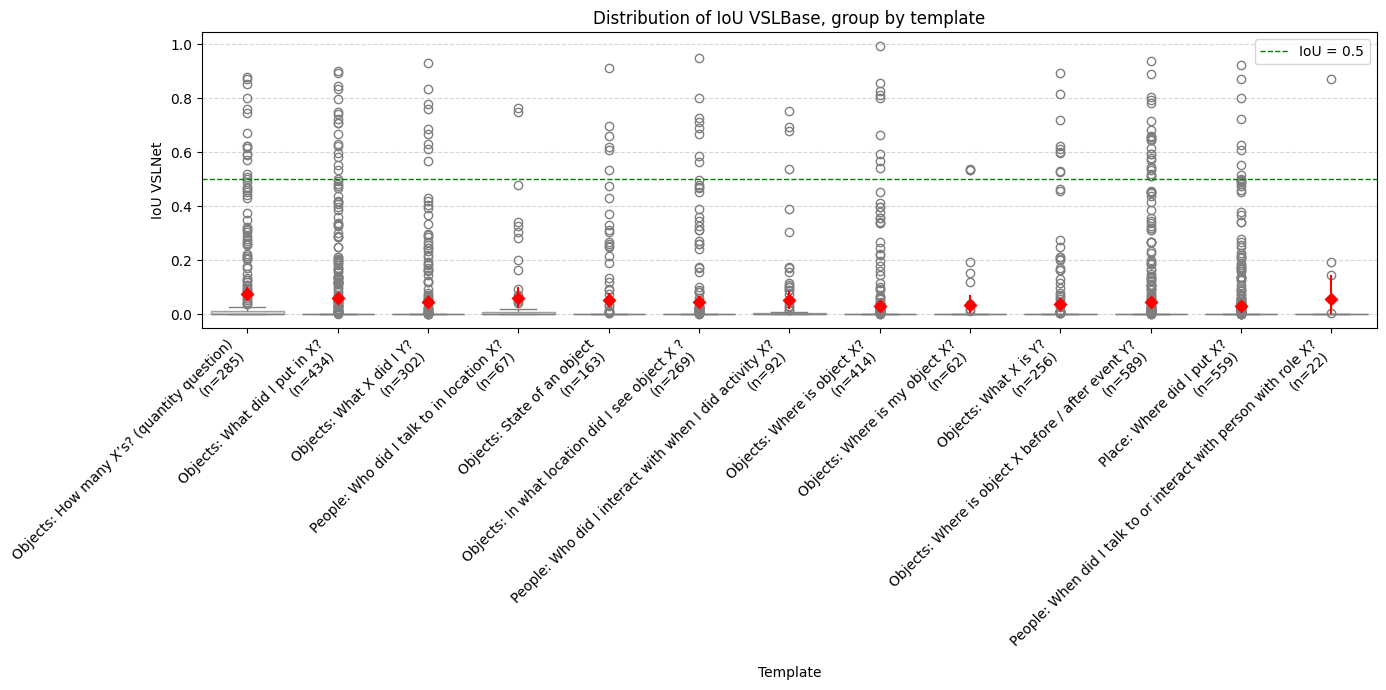

In [ ]:
# Calcolo della media IoU per ordinare i template
media_iou = merged.groupby("template_vslbase")["iou_vslbase"].mean().sort_values(ascending=False)
ordered_templates = media_iou.index

plt.figure(figsize=(14, 7))
sns.boxplot(
    data=merged,
    x="template_vslbase",
    y="iou_vslnet",
    order=ordered_templates,
    color='lightgray',
    boxprops=dict(alpha=0.7)
)

sns.pointplot(
    data=merged,
    x="template_vslnet",
    y="iou_vslnet",
    order=ordered_templates,
    estimator='mean',
    ci=95,
    color='red',
    markers='D',
    linestyles='',
    scale=1.0,
    errwidth=1.5
)

# Aggiungi soglia
plt.axhline(0.5, color='green', linestyle='--', linewidth=1, label='IoU = 0.5')

# Etichette con numero di campioni
counts = merged['template_vslnet'].value_counts()
new_labels = [f"{t}\n(n={counts[t]})" for t in ordered_templates]
plt.xticks(ticks=range(len(new_labels)), labels=new_labels, rotation=45, ha= 'right')

plt.title("Distribution of IoU VSLBase, group by template")
plt.xlabel("Template")
plt.ylabel("IoU VSLNet")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()